In [87]:
import tensorflow as tf

In [88]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

config.gpu_options.per_process_gpu_memory_fraction = 0.3

In [89]:
hello = tf.constant("hello TensorFlow!")

In [90]:
sess = tf.compat.v1.Session()

In [91]:
hello

<tf.Tensor: id=39328, shape=(), dtype=string, numpy=b'hello TensorFlow!'>

In [92]:
x = [[2.]]

In [93]:
print('tensorflow version', tf.__version__)

tensorflow version 2.0.0


In [94]:
print('hello, {}'.format(tf.matmul(x, x)))

hello, [[4.]]


In [95]:
import os

In [96]:
DATA_PATH = './data'
RESULT_PATH = './result'

temp_file = os.path.join(DATA_PATH,'datasets-promise12.zip')
origin = 'https://weisslab.cs.ucl.ac.uk/WEISSTeaching/datasets/-/archive/promise12/datasets-promise12.zip'

In [97]:
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

os.system("wget -P %s  %s" % (DATA_PATH, origin))
os.system('unzip %s -d %s' % (temp_file, DATA_PATH))

if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

print('Promise12 data downloaded: <%s>.' % os.path.abspath(os.path.join(DATA_PATH,'datasets-promise12')))
print('Result directory created: <%s>.' % os.path.abspath(RESULT_PATH))

Promise12 data downloaded: <C:\Windows\system32\data\datasets-promise12>.
Result directory created: <C:\Windows\system32\result>.


In [98]:
import numpy as np
import random
import os

In [99]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"


DATA_PATH = 'C:/segmentation/datasets-promise12'
RESULT_PATH = 'C:/segmentation/result' 

In [100]:
def conv3d(input, filters, downsample=False, activation=True, batch_norm=False):
    if downsample: strides = [1,2,2,2,1]
    else: strides = [1,1,1,1,1]
    y = tf.nn.conv3d(input, filters, strides=strides, padding='SAME')
    if batch_norm: y = batch_norm(y)
    if activation: y = tf.nn.relu(y)
    return y  # where bn can be added

In [101]:
def resnet_block(input, filters, batch_norm=False):
    y = conv3d(input, filters[..., 0])
    y = conv3d(y, filters[..., 1], activation=False) + input
    if batch_norm: y = batch_norm(y)
    return tf.nn.relu(y)  # where bn can be added

In [102]:
def downsample_maxpool(input, filters):
    y = conv3d(input, filters)
    return tf.nn.max_pool3d(y, ksize=[1,3,3,3,1], padding='SAME', strides=[1,2,2,2,1])

In [103]:
def deconv3d(input, filters, out_shape, batch_norm=False):
    y = tf.nn.conv3d_transpose(input, filters, output_shape=out_shape, strides=[1,2,2,2,1], padding='SAME') 
    if batch_norm: y = batch_norm(y)
    return tf.nn.relu(y)  # where bn can be added

In [104]:
def batch_norm(inputs, is_training, decay = 0.999):
    # This is where to insert the implementation of batch normalisaiton
    return inputs

In [105]:
def add_variable(var_shape, var_list, var_name=None, initialiser=None):
    if initialiser is None:
        initialiser = tf.initializers.glorot_normal()
    if var_name is None:
        var_name = 'var{}'.format(len(var_list))
        var_list.append(tf.Variable(initialiser(var_shape), name=var_name, trainable=True))
    return var_list

In [136]:
### Define a model (the 3D U-Net) with residual layers
### ref: https://arxiv.org/abs/1512.03385  & https://arxiv.org/abs/1505.04597
## define all the trinable weights
num_channels = 32
nc = [num_channels*(2**i) for i in range(5)]
var_list=[]
# intial-layer
var_list = add_variable([5,5,5,1,nc[0]], var_list)
# encoder-s0
var_list = add_variable([3,3,3,nc[0],nc[0],2], var_list)
var_list = add_variable([3,3,3,nc[0],nc[0],2], var_list)
var_list = add_variable([3,3,3,nc[0],nc[0]], var_list)
var_list = add_variable([3,3,3,nc[0],nc[1]], var_list)
# encoder-s1
var_list = add_variable([3,3,3,nc[1],nc[1],2], var_list)
var_list = add_variable([3,3,3,nc[1],nc[1],2], var_list)
var_list = add_variable([3,3,3,nc[1],nc[1]], var_list)
var_list = add_variable([3,3,3,nc[1],nc[2]], var_list)
# encoder-s2
var_list = add_variable([3,3,3,nc[2],nc[2],2], var_list)
var_list = add_variable([3,3,3,nc[2],nc[2],2], var_list)
var_list = add_variable([3,3,3,nc[2],nc[2]], var_list)
var_list = add_variable([3,3,3,nc[2],nc[3]], var_list)

# encoder-s3
var_list = add_variable([3,3,3,nc[3],nc[3],2], var_list)
var_list = add_variable([3,3,3,nc[3],nc[3],2], var_list)
var_list = add_variable([3,3,3,nc[3],nc[3]], var_list)
var_list = add_variable([3,3,3,nc[3],nc[4]], var_list)

# deep-layers-s4
var_list = add_variable([3,3,3,nc[4],nc[4],2], var_list)
var_list = add_variable([3,3,3,nc[4],nc[4],2], var_list)
var_list = add_variable([3,3,3,nc[4],nc[4],2], var_list)

# decoder-s3
var_list = add_variable([3,3,3,nc[3],nc[4]], var_list)
var_list = add_variable([3,3,3,nc[3],nc[3],2], var_list)
var_list = add_variable([3,3,3,nc[3],nc[3],2], var_list)

# decoder-s2
var_list = add_variable([3,3,3,nc[2],nc[3]], var_list)
var_list = add_variable([3,3,3,nc[2],nc[2],2], var_list)
var_list = add_variable([3,3,3,nc[2],nc[2],2], var_list)
# decoder-s1
var_list = add_variable([3,3,3,nc[1],nc[2]], var_list)
var_list = add_variable([3,3,3,nc[1],nc[1],2], var_list)
var_list = add_variable([3,3,3,nc[1],nc[1],2], var_list)
# decoder-s0
var_list = add_variable([3,3,3,nc[0],nc[1]], var_list)
var_list = add_variable([3,3,3,nc[0],nc[0],2], var_list)
var_list = add_variable([3,3,3,nc[0],nc[0],2], var_list)
# output-layer
var_list = add_variable([3,3,3,nc[0],1], var_list)

## model with corresponding layers
@tf.function
def residual_unet(input):
    # initial-layer
    skip_layers = []
    layer = conv3d(input, var_list[0])
    # encoder-s0
    layer = resnet_block(layer, var_list[1])
    layer = resnet_block(layer, var_list[2])
    skip_layers.append(layer)
    layer = downsample_maxpool(layer, var_list[3])
    layer = conv3d(layer, var_list[4])
    # encoder-s1
    layer = resnet_block(layer, var_list[5])
    layer = resnet_block(layer, var_list[6])
    skip_layers.append(layer)
    layer = downsample_maxpool(layer, var_list[7])
    layer = conv3d(layer, var_list[8])
    # encoder-s2
    layer = resnet_block(layer, var_list[9])
    layer = resnet_block(layer, var_list[10])
    skip_layers.append(layer)
    layer = downsample_maxpool(layer, var_list[11])
    layer = conv3d(layer, var_list[12])
    
    # encoder-s3
    layer = resnet_block(layer, var_list[13])
    layer = resnet_block(layer, var_list[14])
    skip_layers.append(layer)
    layer = downsample_maxpool(layer, var_list[15])
    layer = conv3d(layer, var_list[16])
    
    # deep-layers-s4
    layer = resnet_block(layer, var_list[17])
    layer = resnet_block(layer, var_list[18])
    layer = resnet_block(layer, var_list[19])
    
    # decoder-s3
    layer = deconv3d(layer, var_list[20], skip_layers[3].shape) + skip_layers[3]
    layer = resnet_block(layer, var_list[21])
    layer = resnet_block(layer, var_list[22])
    # decoder-s2
    layer = deconv3d(layer, var_list[23], skip_layers[2].shape) + skip_layers[2]
    layer = resnet_block(layer, var_list[24])
    layer = resnet_block(layer, var_list[25])
    # decoder-s1
    layer = deconv3d(layer, var_list[26], skip_layers[1].shape) + skip_layers[1]
    layer = resnet_block(layer, var_list[27])
    layer = resnet_block(layer, var_list[28])
    # decoder-s0
    layer = deconv3d(layer, var_list[29], skip_layers[0].shape) + skip_layers[0]
    layer = resnet_block(layer, var_list[30])
    layer = resnet_block(layer, var_list[31])
    # output-layer
    layer = tf.sigmoid(conv3d(layer, var_list[32], activation=False))
    return layer

In [138]:
for i in range(36):
    print(i+1, var_list[i][:0])

1 tf.Tensor([], shape=(0, 5, 5, 1, 32), dtype=float32)
2 tf.Tensor([], shape=(0, 3, 3, 32, 32, 2), dtype=float32)
3 tf.Tensor([], shape=(0, 3, 3, 32, 32, 2), dtype=float32)
4 tf.Tensor([], shape=(0, 3, 3, 32, 32), dtype=float32)
5 tf.Tensor([], shape=(0, 3, 3, 32, 64), dtype=float32)
6 tf.Tensor([], shape=(0, 3, 3, 64, 64, 2), dtype=float32)
7 tf.Tensor([], shape=(0, 3, 3, 64, 64, 2), dtype=float32)
8 tf.Tensor([], shape=(0, 3, 3, 64, 64), dtype=float32)
9 tf.Tensor([], shape=(0, 3, 3, 64, 128), dtype=float32)
10 tf.Tensor([], shape=(0, 3, 3, 128, 128, 2), dtype=float32)
11 tf.Tensor([], shape=(0, 3, 3, 128, 128, 2), dtype=float32)
12 tf.Tensor([], shape=(0, 3, 3, 128, 128), dtype=float32)
13 tf.Tensor([], shape=(0, 3, 3, 128, 256), dtype=float32)
14 tf.Tensor([], shape=(0, 3, 3, 256, 256, 2), dtype=float32)
15 tf.Tensor([], shape=(0, 3, 3, 256, 256, 2), dtype=float32)
16 tf.Tensor([], shape=(0, 3, 3, 256, 256), dtype=float32)
17 tf.Tensor([], shape=(0, 3, 3, 256, 512), dtype=float32)


IndexError: list index out of range

In [139]:
def loss_crossentropy(pred, target):
    return tf.losses.BinaryCrossentropy(pred=pred, target=target)

def loss_dice(pred, target, eps=1e-6):
    dice_numerator = 2 * tf.reduce_sum(pred*target, axis=[1,2,3,4])
    dice_denominator = eps + tf.reduce_sum(pred, axis=[1,2,3,4]) + tf.reduce_sum(target, axis=[1,2,3,4])
    return  1 - tf.reduce_mean(dice_numerator/dice_denominator)

In [140]:
### a simple npy image reading class
class DataReader:
    def __init__(self, folder_name):
        self.folder_name = folder_name
    def load_images_train(self, indices_mb):
        return self.load_npy_files(["image_train%02d.npy" % idx for idx in indices_mb])
    def load_images_test(self, indices_mb):
        return self.load_npy_files(["image_test%02d.npy" % idx for idx in indices_mb])
    def load_labels_train(self, indices_mb):
        return self.load_npy_files(["label_train%02d.npy" % idx for idx in indices_mb])
    def load_npy_files(self, file_names):
        images = [np.float32(np.load(os.path.join(self.folder_name, fn))) for fn in file_names]
        return np.expand_dims(np.stack(images, axis=0), axis=4)

In [141]:
### training
@tf.function
def train_step(model, weights, optimizer, x, y):
    with tf.GradientTape() as tape:
        # g_tape.watched(var_list): trainable variables are automatically "watched".
        loss = loss_dice(model(x), y)
    gradients = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(gradients, weights))
    return loss
learning_rate = 1e-5
total_iter = int(1e6)
n = 50  # 50 training image-label pairs
size_minibatch = 4

num_minibatch = int(n/size_minibatch)  # how many minibatches in each epoch
indices_train = [i for i in range(n)]

DataFeeder = DataReader(DATA_PATH)
optimizer = tf.optimizers.Adam(learning_rate)
for step in range(total_iter):

    # shuffle data every time start a new set of minibatches
    if step in range(0, total_iter, num_minibatch):
        random.shuffle(indices_train)

    # find out data indices for a minibatch
    minibatch_idx = step % num_minibatch  # minibatch index
    indices_mb = indices_train[minibatch_idx*size_minibatch:(minibatch_idx+1)*size_minibatch]
    # halve image size so this can be reasonably tested, e.g. on a CPU
    input_mb = DataFeeder.load_images_train(indices_mb)[:, ::2, ::2, ::2, :]
    label_mb = DataFeeder.load_labels_train(indices_mb)[:, ::2, ::2, ::2, :]
    # update the variables
    loss_train = train_step(residual_unet, var_list, optimizer, input_mb, label_mb)

    # print training information
    if (step % 100) == 0:
        tf.print('Step', step, ': training-loss=', loss_train)

    # --- simple tests during training ---
    if (step % 1000) == 0:
        indices_test = [random.randrange(30) for i in range(size_minibatch)]  # select size_minibatch test data
        input_test = DataFeeder.load_images_test(indices_test)[:, ::2, ::2, ::2, :]
        pred_test = residual_unet(input_test)
        # save the segmentation
        for idx in range(size_minibatch):
            np.save(os.path.join(RESULT_PATH, "label_test%02d_step%06d.npy" % (indices_test[idx], step)), pred_test[idx, ...])
        tf.print('Test results saved.')

Step 0 : training-loss= 0.957348883
Test results saved.
Step 100 : training-loss= 0.77859056
Step 200 : training-loss= 0.47944808
Step 300 : training-loss= 0.392882466
Step 400 : training-loss= 0.315844893
Step 500 : training-loss= 0.306986213
Step 600 : training-loss= 0.288890481
Step 700 : training-loss= 0.343784332
Step 800 : training-loss= 0.193007052
Step 900 : training-loss= 0.294895411
Step 1000 : training-loss= 0.26425612
Test results saved.
Step 1100 : training-loss= 0.286691964
Step 1200 : training-loss= 0.192299545
Step 1300 : training-loss= 0.215794921
Step 1400 : training-loss= 0.235450149
Step 1500 : training-loss= 0.161717772
Step 1600 : training-loss= 0.209407926
Step 1700 : training-loss= 0.190185547
Step 1800 : training-loss= 0.143687606
Step 1900 : training-loss= 0.15045476
Step 2000 : training-loss= 0.166764021
Test results saved.
Step 2100 : training-loss= 0.16616261
Step 2200 : training-loss= 0.19802475
Step 2300 : training-loss= 0.202477515
Step 2400 : training-l

KeyboardInterrupt: 

In [142]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [143]:
slices_to_plot = [2,5,8,11,14]  # must be smaller than total number of slices

Label loaded: C:/segmentation/result\label_test02_step002000.npy.
(16, 64, 64)


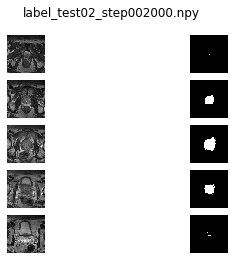

Label loaded: C:/segmentation/result\label_test03_step004000.npy.
(16, 64, 64)


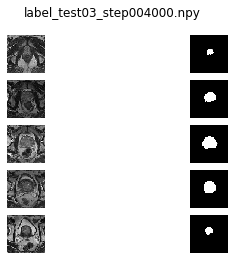

Label loaded: C:/segmentation/result\label_test04_step005000.npy.
(16, 64, 64)


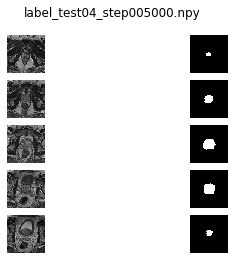

Label loaded: C:/segmentation/result\label_test04_step007000.npy.
(16, 64, 64)


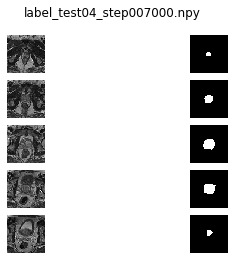

Label loaded: C:/segmentation/result\label_test06_step001000.npy.
(16, 64, 64)


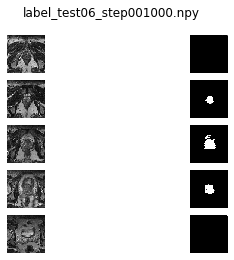

Label loaded: C:/segmentation/result\label_test06_step005000.npy.
(16, 64, 64)


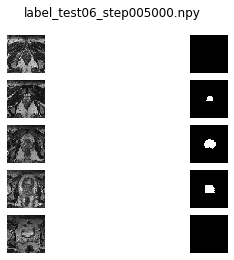

Label loaded: C:/segmentation/result\label_test08_step004000.npy.
(16, 64, 64)


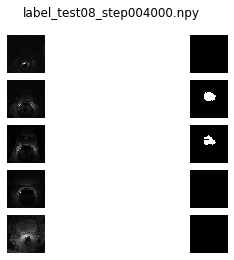

Label loaded: C:/segmentation/result\label_test09_step006000.npy.
(16, 64, 64)


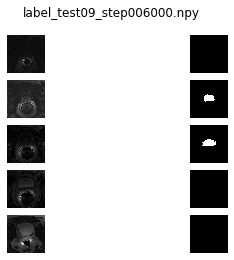

Label loaded: C:/segmentation/result\label_test10_step006000.npy.
(16, 64, 64)


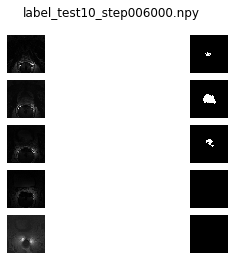

Label loaded: C:/segmentation/result\label_test12_step000000.npy.
(16, 64, 64)


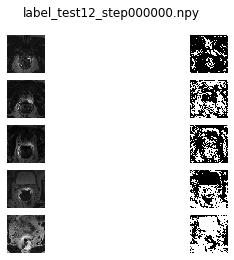

Label loaded: C:/segmentation/result\label_test12_step004000.npy.
(16, 64, 64)


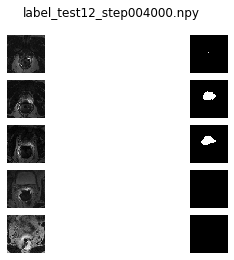

Label loaded: C:/segmentation/result\label_test13_step000000.npy.
(16, 64, 64)


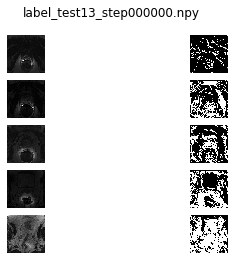

Label loaded: C:/segmentation/result\label_test13_step002000.npy.
(16, 64, 64)


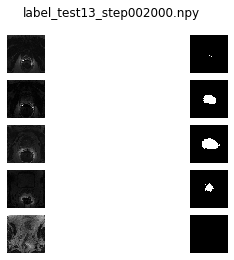

Label loaded: C:/segmentation/result\label_test13_step003000.npy.
(16, 64, 64)


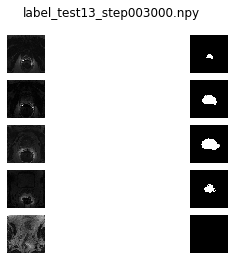

Label loaded: C:/segmentation/result\label_test14_step007000.npy.
(16, 64, 64)


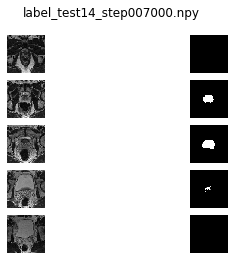

Label loaded: C:/segmentation/result\label_test15_step003000.npy.
(16, 64, 64)


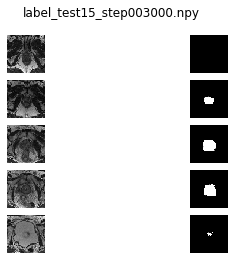

Label loaded: C:/segmentation/result\label_test17_step001000.npy.
(16, 64, 64)


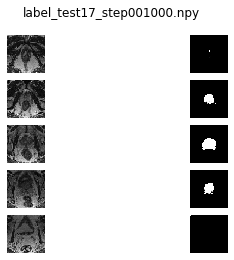

Label loaded: C:/segmentation/result\label_test17_step003000.npy.
(16, 64, 64)


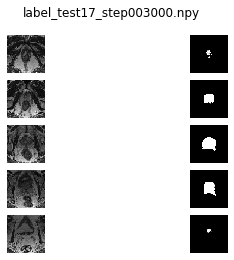

Label loaded: C:/segmentation/result\label_test17_step004000.npy.
(16, 64, 64)


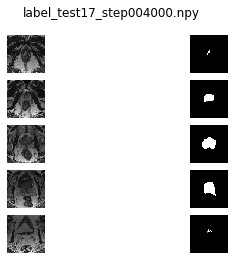

Label loaded: C:/segmentation/result\label_test17_step005000.npy.
(16, 64, 64)


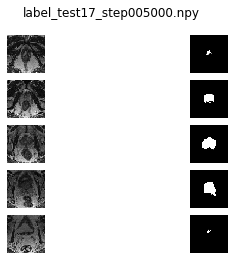

Label loaded: C:/segmentation/result\label_test18_step000000.npy.
(16, 64, 64)


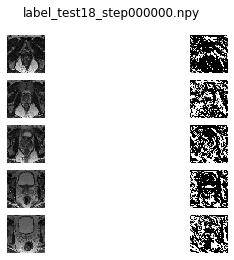

Label loaded: C:/segmentation/result\label_test18_step002000.npy.
(16, 64, 64)


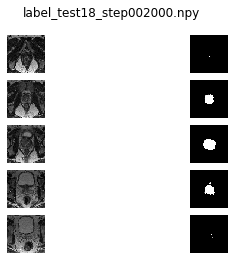

Label loaded: C:/segmentation/result\label_test22_step005000.npy.
(16, 64, 64)


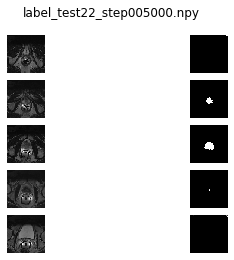

Label loaded: C:/segmentation/result\label_test24_step003000.npy.
(16, 64, 64)


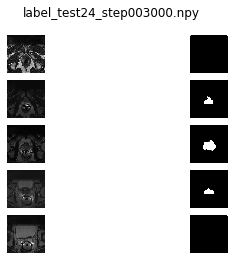

Label loaded: C:/segmentation/result\label_test25_step006000.npy.
(16, 64, 64)


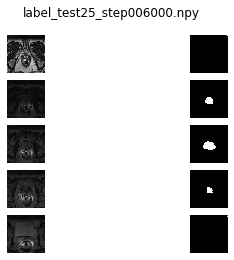

Label loaded: C:/segmentation/result\label_test26_step000000.npy.
(16, 64, 64)


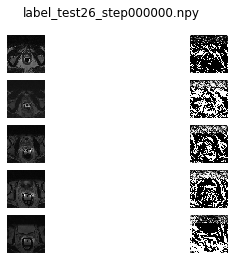

Label loaded: C:/segmentation/result\label_test27_step007000.npy.
(16, 64, 64)


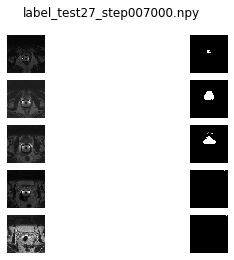

Label loaded: C:/segmentation/result\label_test28_step001000.npy.
(16, 64, 64)


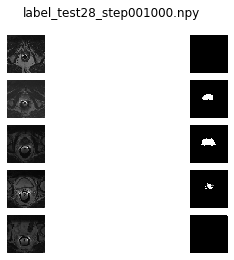

Label loaded: C:/segmentation/result\label_test28_step002000.npy.
(16, 64, 64)


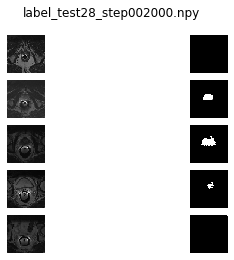

Label loaded: C:/segmentation/result\label_test29_step001000.npy.
(16, 64, 64)


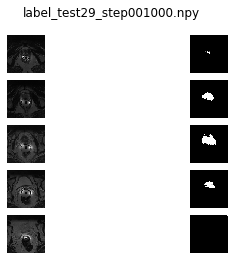

In [144]:
# find all the available results
for filename in os.listdir(RESULT_PATH):
    if filename.endswith(".npy"):
        print('Label loaded: %s.' % os.path.join(RESULT_PATH, filename))
        label = np.load(os.path.join(RESULT_PATH, filename))[..., 0]
        image = np.load(os.path.join(DATA_PATH, "image_"+filename.split('_')[1]+".npy"))[::2, ::2, ::2]
        print(label.shape)
        plt.figure()
        plt.suptitle(filename)
        for idx in range(len(slices_to_plot)):
            axs = plt.subplot(len(slices_to_plot),2,idx*2+1)
            axs.imshow(image[slices_to_plot[idx],:,:], cmap='gray')
            axs.axis('off')
            axs = plt.subplot(len(slices_to_plot),2,idx*2+2)
            axs.imshow(label[slices_to_plot[idx],:,:], cmap='gray')
            axs.axis('off')
        plt.ion()
        plt.show()